In [110]:
pip install pyarrow pandas_ta seaborn matplotlib scikit-learn==1.3.1 yfinance tensorflow.keras



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [111]:
import pandas as pd
import pandas_ta as ta
from numpy import NaN
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score , mean_absolute_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor,RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBRegressor, XGBClassifier
from sklearn.model_selection import GridSearchCV
import warnings
from sklearn.linear_model import LogisticRegression
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

import os
import yfinance as yf
warnings.filterwarnings("ignore")


In [112]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings
import yfinance as yf
warnings.filterwarnings("ignore")

# df must have index as datetime64[ns], and 'signal' column
# freq can be 'daily', 'hourly', or 'minute'
def run_backtest(df, freq='h',name=""):

  # check if df.index is datetime64[ns]
  if df.index.dtype != 'datetime64[ns]':
    raise ValueError("df.index must be in datetime64[ns]")

  # ------------------ Return Data Preparation ------------------
  if 'return_forward' in df.columns:
    df = df.drop(columns=['return_forward'])

  if freq == 'd':
    df = concat_return(df, freq)
    period_in_a_year = 365
  elif freq == 'h':
    df = concat_return(df, freq)
    period_in_a_year = 365 * 24
  elif freq == '5min':
    df = concat_return(df, freq)
    period_in_a_year = 365 * 24 * 12
  elif freq == '15min':
    df = concat_return(df, freq)
    period_in_a_year = 365 * 24 * 4
  else:
    raise ValueError("Invalid freq argument. Must be 'd', 'h', '5min', or '15min'")

  # ------------------ Data check ------------------
  if df['signal'].isnull().values.any():
    raise ValueError("DataFrame contains NA values")
  if 'signal' not in df.columns:
    raise ValueError("DataFrame is missing required column: 'signal'")

  # ------------------ Return & Sharpe ------------------
  # Daily returns
  df['strategy_return'] = df['signal'] * df['return_forward']

  # Geometric Annual Return
  num_periods = len(df)
  annual_return_geometric = (1 + df['strategy_return']).prod()**(period_in_a_year/num_periods) - 1
  
  # Arithmetic Annual Return for sharpe ratio calculation
  annual_return_arithmetic = df['strategy_return'].mean() * period_in_a_year

  # Sharpe Ratio
  daily_std = df['strategy_return'].std()
  annual_std = daily_std * np.sqrt(period_in_a_year)
  overall_sharpe = annual_return_arithmetic / annual_std

  print(f"Overall Annual Return: {round(annual_return_geometric*100, 2)}%")
  print("Overall Annual Sharpe Ratio:", round(overall_sharpe, 4))

  # ------------------ Maximum Drawdown ------------------
  df['cum_return'] = (1 + df['strategy_return']).cumprod()
  rolling_max = df['cum_return'].cummax()
  df['drawdown'] = (df['cum_return'] - rolling_max) / rolling_max
  max_drawdown = df['drawdown'].min()
  print("Maximum Drawdown:", round(max_drawdown * 100, 2), "%")

  # ------------------ Win/Loss Ratio ------------------
  # winning_trades = (df['strategy_return'] > 0).sum()
  # losing_trades = (df['strategy_return'] < 0).sum()
  # if losing_trades > 0:
  #   win_loss_ratio = winning_trades / losing_trades
  # else:
  #   win_loss_ratio = np.nan # no losing trades (advoid division by zero)
  # print("Win/Loss Ratio:", round(win_loss_ratio, 4))

  # ------------------ Alpha and Beta ------------------
  # Beta = Cov(strategy_return, acutal_return) / Var(actual_return)
  cov_matrix = np.cov(df['strategy_return'], df['return_forward'])
  beta = cov_matrix[0, 1] / cov_matrix[1, 1]

  # Alpha = mean(strategy_return) - Beta * mean(actual_return)
  alpha_daily = df['strategy_return'].mean() - beta * df['return_forward'].mean()

  # Annualize alpha
  alpha_annualized = (1 + alpha_daily) ** period_in_a_year - 1

  print("Alpha:", round(alpha_annualized, 4))
  print("Beta:", round(beta, 4))

  # ------------------- Yearly Metrics -------------------
  df['year'] = df.index.year

  yearly_data = df.groupby('year').apply(lambda subdf: pd.Series({
    'yearly_return': (1 + subdf['strategy_return']).prod()**(period_in_a_year/len(subdf)) - 1,
    'yearly_return_arithmetic': subdf['strategy_return'].mean() * period_in_a_year,
    'yearly_std': subdf['strategy_return'].std() * np.sqrt(period_in_a_year),
    'yearly_beta': np.cov(subdf['strategy_return'], subdf['return_forward'])[0,1] /
                    np.cov(subdf['strategy_return'], subdf['return_forward'])[1,1],
    'yearly_alpha': (
      subdf['strategy_return'].mean()
      - (
        np.cov(subdf['strategy_return'], subdf['return_forward'])[0,1]
        / np.cov(subdf['strategy_return'], subdf['return_forward'])[1,1]
      )
      * subdf['return_forward'].mean()
    ) * period_in_a_year
  })).reset_index()

  yearly_data['yearly_sharpe'] = yearly_data['yearly_return_arithmetic'] / yearly_data['yearly_std']
  yearly_data.drop(columns=['yearly_return_arithmetic'], inplace=True)
  print("\nYearly Metrics:")
  print(yearly_data)

  # ------------------------- Plots ----------------------
  df['cum_return_plot'] = (1 + df['strategy_return']).cumprod() - 1
  df['bh_cum_return_plot'] = (1 + df['return_forward']).cumprod() - 1

  # cumulative return plot
  plt.figure(figsize=(8,4))
  plt.plot(df.index, df['cum_return_plot'], label='Strategy Return')
  plt.plot(df.index, df['bh_cum_return_plot'], label='Buy and Hold')
  plt.title('Strategy Cumulative Return')
  plt.xlabel('Date')
  plt.ylabel('Cumulative Return')
  plt.legend()
  plt.savefig(f'{name}_cumulative_return.png')
  plt.show()

  # Signal weight plot
  plt.figure(figsize=(8,4))
  plt.plot(df.index, df['signal'], label='Signal')
  plt.title('Signal Weight Over Time')
  plt.xlabel('Date')
  plt.ylabel('Weight')
  plt.legend()
  plt.savefig(f'{name}_signal_weight.png')
  plt.show()


def concat_return(df, freq='h'):
  if freq == 'd':
    file_path = "../../bitcoin_historical_price/btcusd_daily_price.parquet"
  elif freq == 'h':
    file_path = "../../bitcoin_historical_price/btcusd_hourly_price.parquet"
  elif freq == '5min':
    file_path = "../../bitcoin_historical_price/btcusd_5min_price.parquet"
  elif freq == '15min':
    file_path = "../../bitcoin_historical_price/btcusd_15min_price.parquet"
  else:
    raise ValueError("Invalid freq argument. Must be 'd', 'h', '5min', or '15min'")

  if os.path.exists(file_path):
    df_btc_return = pd.read_parquet(file_path)
  else:
    raise FileNotFoundError("Check file path: return data not found.")

  # merge return_forward to df
  merged_df = pd.merge(df, df_btc_return[['return_forward']], left_index=True, right_index=True, how='inner')

  # turn return_forward from decimal to float
  merged_df['return_forward'] = merged_df['return_forward'].apply(lambda x: float(x))
  return merged_df

In [113]:
price_indicator = pd.read_parquet("/workspaces/fyp/bitcoin_historical_price/btcusd_hourly_price_indicators.parquet")
df = pd.read_parquet("../data/full_dataset_feature_engineering_v2.parquet")

In [114]:
df.drop("target",axis=1)


,news_count,tanalysis_absa,economy_absa,regulation_absa,technology_absa,adoption_absa,cybersecurity_absa,return_forward,sma_5_20_diff,sma_20_50_diff,...,NER_michael saylor_last24,NER_microstrategy_last3,NER_microstrategy_last24,NER_sec_last3,NER_sec_last24,NER_us_last3,reddit_total_sentiment_ewm_5h,reddit_total_sentiment_ewm_24h,reddit_average_sentiment_ewm_5h,reddit_average_sentiment_ewm_24h
2021-01-01 06:00:00,2.0,0.850000,0.000000,0.000000,0.000000,0.150000,0.0,-0.007795,219.4000,351.4194,...,0,0,0,0,0,0,-0.891000,-0.891000,-0.111375,-0.111375
2021-01-01 07:00:00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.003292,253.0935,336.2693,...,0,0,0,0,0,0,-0.594000,-0.819720,-0.074250,-0.102465
2021-01-01 08:00:00,2.0,0.400000,0.000000,0.000000,0.000000,0.500000,0.0,-0.001883,284.9410,309.6284,...,1,1,1,0,0,0,-0.396000,-0.754142,-0.049500,-0.094268
2021-01-01 09:00:00,2.0,-0.050000,0.000000,0.000000,0.000000,0.400000,0.0,-0.001648,326.5890,301.5680,...,1,1,1,0,0,0,-0.264000,-0.693811,-0.033000,-0.086726
2021-01-01 10:00:00,3.0,0.766667,0.000000,0.000000,0.000000,0.300000,0.0,0.000118,351.1670,289.6874,...,1,1,1,0,0,0,-0.176000,-0.638306,-0.022000,-0.079788
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-31 19:00:00,7.0,0.342857,0.157143,0.114286,0.014286,0.471429,0.0,-0.006308,339.3000,312.8600,...,1,1,1,1,1,1,0.369066,0.208662,0.026292,0.015598
2024-12-31 20:00:00,6.0,0.216667,0.016667,0.083333,0.000000,0.483333,0.0,0.002858,-30.2000,309.9000,...,1,0,1,1,1,1,0.246044,0.191969,0.017528,0.014350
2024-12-31 21:00:00,3.0,0.100000,0.233333,0.200000,0.000000,0.300000,0.0,-0.004142,-238.4500,313.7300,...,1,0,1,1,1,1,0.164029,0.176611,0.011685,0.013202
2024-12-31 22:00:00,4.0,0.200000,0.200000,0.475000,0.000000,0.925000,0.0,0.000933,-365.3000,310.7600,...,1,0,1,0,1,1,0.319753,0.212978,0.017354,0.014441


In [115]:
df

,news_count,tanalysis_absa,economy_absa,regulation_absa,technology_absa,adoption_absa,cybersecurity_absa,return_forward,sma_5_20_diff,sma_20_50_diff,...,NER_michael saylor_last24,NER_microstrategy_last3,NER_microstrategy_last24,NER_sec_last3,NER_sec_last24,NER_us_last3,reddit_total_sentiment_ewm_5h,reddit_total_sentiment_ewm_24h,reddit_average_sentiment_ewm_5h,reddit_average_sentiment_ewm_24h
2021-01-01 06:00:00,2.0,0.850000,0.000000,0.000000,0.000000,0.150000,0.0,-0.007795,219.4000,351.4194,...,0,0,0,0,0,0,-0.891000,-0.891000,-0.111375,-0.111375
2021-01-01 07:00:00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.003292,253.0935,336.2693,...,0,0,0,0,0,0,-0.594000,-0.819720,-0.074250,-0.102465
2021-01-01 08:00:00,2.0,0.400000,0.000000,0.000000,0.000000,0.500000,0.0,-0.001883,284.9410,309.6284,...,1,1,1,0,0,0,-0.396000,-0.754142,-0.049500,-0.094268
2021-01-01 09:00:00,2.0,-0.050000,0.000000,0.000000,0.000000,0.400000,0.0,-0.001648,326.5890,301.5680,...,1,1,1,0,0,0,-0.264000,-0.693811,-0.033000,-0.086726
2021-01-01 10:00:00,3.0,0.766667,0.000000,0.000000,0.000000,0.300000,0.0,0.000118,351.1670,289.6874,...,1,1,1,0,0,0,-0.176000,-0.638306,-0.022000,-0.079788
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-31 19:00:00,7.0,0.342857,0.157143,0.114286,0.014286,0.471429,0.0,-0.006308,339.3000,312.8600,...,1,1,1,1,1,1,0.369066,0.208662,0.026292,0.015598
2024-12-31 20:00:00,6.0,0.216667,0.016667,0.083333,0.000000,0.483333,0.0,0.002858,-30.2000,309.9000,...,1,0,1,1,1,1,0.246044,0.191969,0.017528,0.014350
2024-12-31 21:00:00,3.0,0.100000,0.233333,0.200000,0.000000,0.300000,0.0,-0.004142,-238.4500,313.7300,...,1,0,1,1,1,1,0.164029,0.176611,0.011685,0.013202
2024-12-31 22:00:00,4.0,0.200000,0.200000,0.475000,0.000000,0.925000,0.0,0.000933,-365.3000,310.7600,...,1,0,1,0,1,1,0.319753,0.212978,0.017354,0.014441


# Statistical Feature Selection

In [116]:
train_start_date = pd.to_datetime("2021-01-01 10:00:00")
train_end_date = pd.to_datetime("2023-12-31 23:00:00")

test_start_date = pd.to_datetime("2024-01-01 00:00:00")
test_end_date = pd.to_datetime("2024-12-31 23:00:00")


# Filter rows starting from 2024-01-01 00:00
price_indicator_train = df.loc[train_start_date:train_end_date]
price_indicator_train_X = price_indicator_train.drop("return_forward",axis=1)
price_indicator_train_Y = price_indicator_train["return_forward"]

price_indicator_test = df.loc[test_start_date:test_end_date]
price_indicator_test_X = price_indicator_test.drop("return_forward",axis=1)
price_indicator_test_Y = price_indicator_test["return_forward"]

price_indicator_test


,news_count,tanalysis_absa,economy_absa,regulation_absa,technology_absa,adoption_absa,cybersecurity_absa,return_forward,sma_5_20_diff,sma_20_50_diff,...,NER_michael saylor_last24,NER_microstrategy_last3,NER_microstrategy_last24,NER_sec_last3,NER_sec_last24,NER_us_last3,reddit_total_sentiment_ewm_5h,reddit_total_sentiment_ewm_24h,reddit_average_sentiment_ewm_5h,reddit_average_sentiment_ewm_24h
2024-01-01 00:00:00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,-0.001385,143.55,210.51,...,1,1,1,0,1,0,0.071577,0.097778,0.003539,0.010173
2024-01-01 01:00:00,1.0,-0.300000,0.000000,0.000000,0.000000,0.200000,0.0,-0.000729,151.35,210.81,...,1,0,1,0,1,0,0.047718,0.089956,0.002359,0.009359
2024-01-01 02:00:00,3.0,-0.233333,0.000000,-0.066667,0.000000,0.333333,0.0,-0.005929,120.60,219.66,...,1,0,1,1,1,0,0.249945,0.135111,0.028840,0.015154
2024-01-01 03:00:00,4.0,0.250000,0.000000,-0.500000,0.000000,-0.175000,0.0,0.000095,43.45,223.39,...,1,0,1,1,1,0,0.166630,0.124302,0.019226,0.013942
2024-01-01 04:00:00,2.0,0.000000,0.000000,-0.450000,0.000000,0.150000,0.0,0.005017,-37.10,221.12,...,1,0,1,1,1,1,0.111087,0.114358,0.012818,0.012827
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-31 19:00:00,7.0,0.342857,0.157143,0.114286,0.014286,0.471429,0.0,-0.006308,339.30,312.86,...,1,1,1,1,1,1,0.369066,0.208662,0.026292,0.015598
2024-12-31 20:00:00,6.0,0.216667,0.016667,0.083333,0.000000,0.483333,0.0,0.002858,-30.20,309.90,...,1,0,1,1,1,1,0.246044,0.191969,0.017528,0.014350
2024-12-31 21:00:00,3.0,0.100000,0.233333,0.200000,0.000000,0.300000,0.0,-0.004142,-238.45,313.73,...,1,0,1,1,1,1,0.164029,0.176611,0.011685,0.013202
2024-12-31 22:00:00,4.0,0.200000,0.200000,0.475000,0.000000,0.925000,0.0,0.000933,-365.30,310.76,...,1,0,1,0,1,1,0.319753,0.212978,0.017354,0.014441


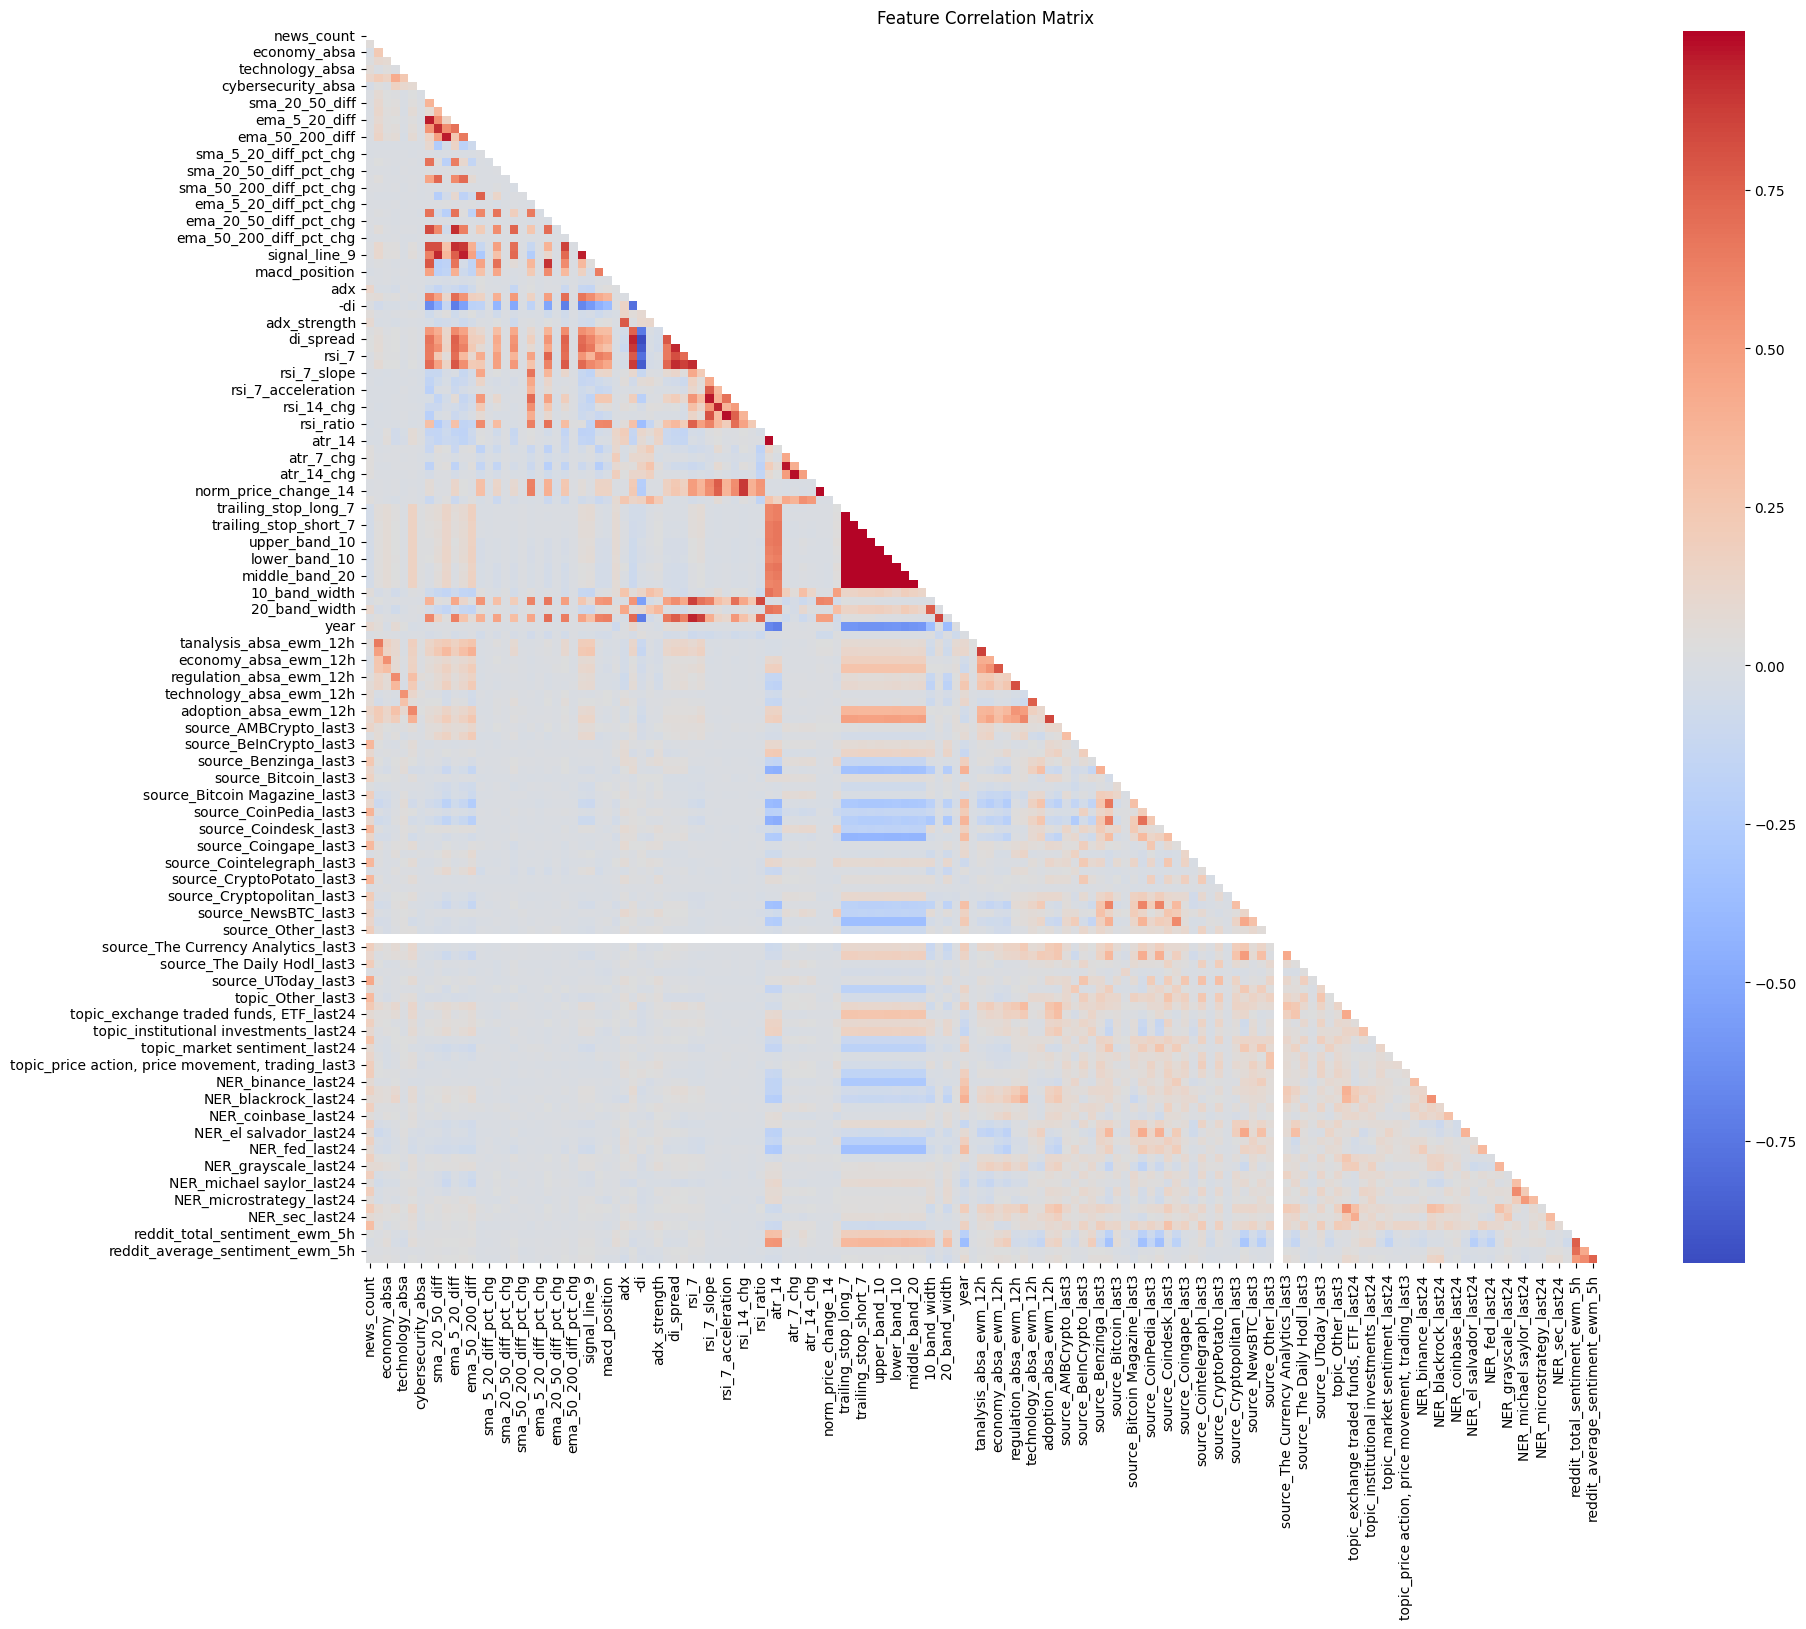

In [117]:
X = price_indicator_train_X
y = price_indicator_train_Y


plt.figure(figsize=(20, 16))
correlation_matrix = X.corr()
mask = np.triu(correlation_matrix)
sns.heatmap(correlation_matrix, mask=mask, annot=False, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()



In [118]:
import pickle
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler

# Load the scalers and feature list
with open('./pickles/stat_feature_scaler.pkl', 'rb') as file:
    feature_scaler = pickle.load(file)

with open('./pickles/stat_target_scaler.pkl', 'rb') as file:
    target_scaler = pickle.load(file)

with open('./pickles/stat_selected_features.pkl', 'rb') as file:
    selected_features = pickle.load(file)

In [119]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

X_df = df[selected_features].values
y_df = df['return_forward'].values  # Replace with your target column name
original_indexes = df.index.tolist()

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_df)

# If your target needs scaling too (for regression problems)
y_scaler = MinMaxScaler()
y_scaled = y_scaler.fit_transform(y_df.reshape(-1, 1))

# Define sequence length (time steps to look back)
sequence_length = 12  # Adjust based on your specific problem

# Create sequences for LSTM
X_sequences = []
y_sequences = []
sequence_indexes = []

for i in range(len(X_scaled) - sequence_length):
    X_sequences.append(X_scaled[i:i+sequence_length])
    y_sequences.append(y_scaled[i+sequence_length])
    sequence_indexes.append(original_indexes[i+sequence_length])

# Convert to numpy arrays
X_sequences = np.array(X_sequences)
y_sequences = np.array(y_sequences)

# Check the resulting shapes
print(f"X shape: {X_sequences.shape}")  # Should be (samples, sequence_length, num_features)
print(f"y shape: {y_sequences.shape}")  # Should be (samples, 1) or (samples,)

# Split into training and testing sets

X_train, X_test, y_train, y_test ,train_idx, test_idx = train_test_split(
    X_sequences, y_sequences, sequence_indexes, test_size=0.25062, shuffle=False
)

print(f"Total sequences: {len(sequence_indexes)}")
print(f"Training sequences: {len(train_idx)}")
print(f"Testing sequences: {len(test_idx)}")


X shape: (35046, 12, 15)
y shape: (35046, 1)
Total sequences: 35046
Training sequences: 26262
Testing sequences: 8784


In [120]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K
from keras.saving import register_keras_serializable


from keras.callbacks import LearningRateScheduler

# Define learning rate schedule function
def lr_schedule(epoch, lr):
    if epoch < 10:
        return lr
    elif epoch < 20:
        return lr * 0.1
    else:
        return lr * 0.01

# Create learning rate scheduler callback
lr_scheduler = LearningRateScheduler(lr_schedule)



@register_keras_serializable(package="Custom", name="weighted_loss")
def weighted_loss(y_true, y_pred):
    # Calculate returns
    returns = y_pred - y_true
    
    # Define weights for positive and negative returns
    positive_weight = 0.5
    negative_weight = 1.5
    
    # Calculate weighted loss
    loss = K.mean(K.switch(returns > 0, positive_weight * K.square(returns), negative_weight * K.square(returns)))
    
    return loss


# Define model architecture
model = Sequential()
model.add(LSTM(64, activation='relu', return_sequences=True, 
               input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))  # Output layer - 1 neuron for regression

# Compile model
model.compile(optimizer='adam', loss=weighted_loss)

# Add early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping,lr_scheduler],
    verbose=1
)

# Evaluate model
loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")

# Make predictions
predictions = model.predict(X_test)

# Inverse transform predictions to original scale (if you scaled y)
predictions = y_scaler.inverse_transform(predictions)
y_test_actual = y_scaler.inverse_transform(y_test)
predictions

Epoch 1/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.0173 - val_loss: 7.1655e-04 - learning_rate: 0.0010
Epoch 2/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0030 - val_loss: 2.3431e-04 - learning_rate: 0.0010
Epoch 3/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0021 - val_loss: 4.4243e-04 - learning_rate: 0.0010
Epoch 4/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0015 - val_loss: 3.3096e-04 - learning_rate: 0.0010
Epoch 5/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0012 - val_loss: 2.8131e-04 - learning_rate: 0.0010
Epoch 6/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 9.6566e-04 - val_loss: 2.5910e-04 - learning_rate: 0.0010
Epoch 7/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 9.2713e-04 - val_loss: 2.3492e-04 - learning_rate: 0.0010
Epoch 8/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 8.9811e-04 - val_loss: 2.3404e-04 - learning_rate: 0.0010
Epoch 9/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 9.1760e

array([[0.00194593],
       [0.00184243],
       [0.00170167],
       ...,
       [0.0008662 ],
       [0.00087069],
       [0.00090337]], dtype=float32)

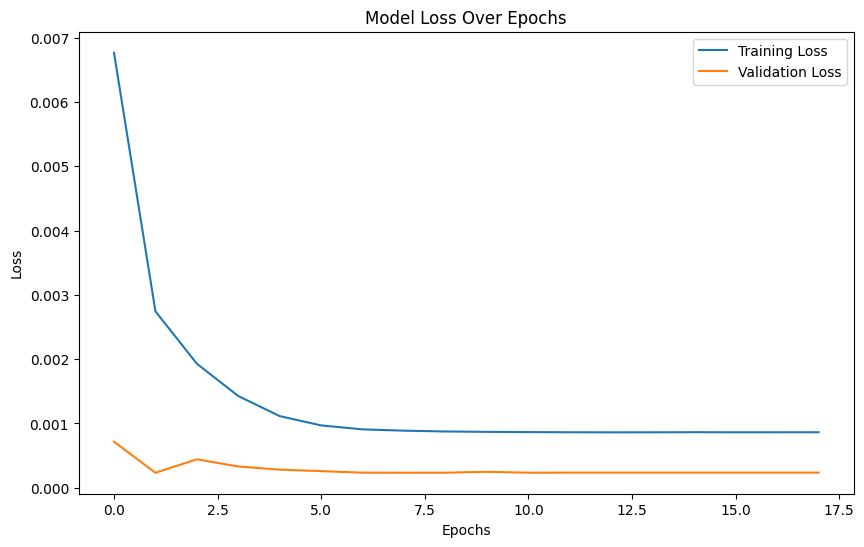

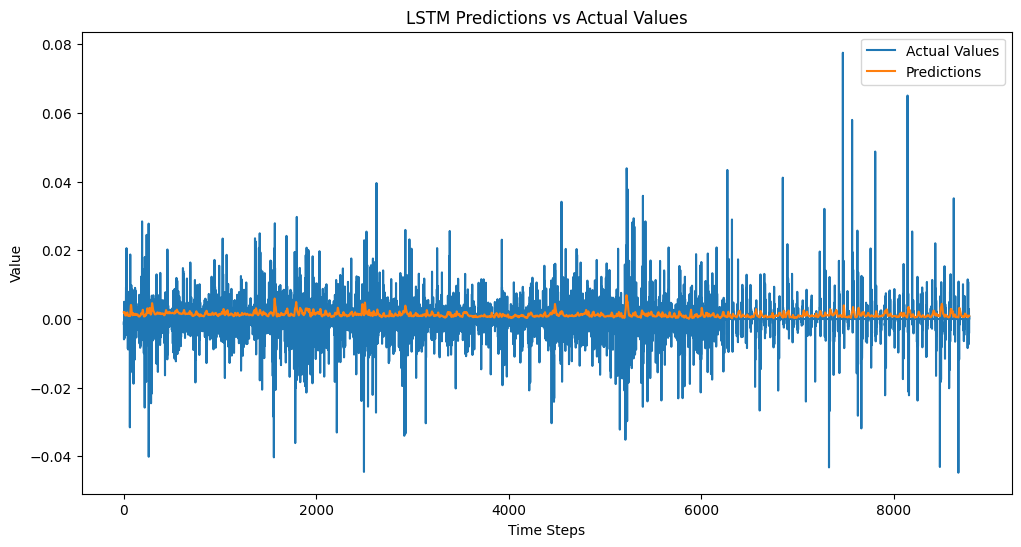

In [121]:
import matplotlib.pyplot as plt

# Plot loss history (for Keras model)
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot predictions vs actual values
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label='Actual Values')
plt.plot(predictions, label='Predictions')
plt.title('LSTM Predictions vs Actual Values')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.legend()
plt.show()

In [122]:
# import pickle

# # Save feature scaler
# with open('stat_feature_scaler.pkl', 'wb') as file:
#     pickle.dump(scaler, file)

# # Save target scaler (if used)
# with open('stat_target_scaler.pkl', 'wb') as file:
#     pickle.dump(y_scaler, file)
    
# # Save feature list
# with open('stat_selected_features.pkl', 'wb') as file:
#     pickle.dump(selected_features, file)
model.save('stat_features_selection_lstm_model_C0.keras')  # HDF5 format


In [123]:
y_test

array([[0.49584198],
       [0.49849705],
       [0.47746212],
       ...,
       [0.48469075],
       [0.50521762],
       [0.502052  ]])

In [153]:
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

model = load_model('stat_features_selection_lstm_model_C0.keras')  # Your saved model
predictions = model.predict(X_test)
predictions = y_scaler.inverse_transform(predictions)
y_test_actual = y_scaler.inverse_transform(y_test)

# Create DataFrame with predictions and actual values with proper indexes
results_df = pd.DataFrame({
    'Actual': y_test_actual.flatten(),
    'Predicted': predictions.flatten()
}, index=test_idx)
results_df


275/275 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


,Actual,Predicted
2024-01-01 00:00:00,-0.001385,0.007216
2024-01-01 01:00:00,-0.000729,0.007493
2024-01-01 02:00:00,-0.005929,0.007513
2024-01-01 03:00:00,0.000095,0.007577
2024-01-01 04:00:00,0.005017,0.007205
...,...,...
2024-12-31 19:00:00,-0.006308,0.007363
2024-12-31 20:00:00,0.002858,0.007089
2024-12-31 21:00:00,-0.004142,0.006152
2024-12-31 22:00:00,0.000933,0.005725


In [158]:
stat_signal_result_df = results_df.drop("Actual",axis=1)
stat_signal_result_df['signal'] = stat_signal_result_df['Predicted'].apply(lambda x: 1 if x > 0.005 else (-1 if x < 0.002 else 0))
stat_signal_result_df['target'] = results_df['Actual'].apply(lambda x: 1 if x > 0.005 else (-1 if x < 0.002 else 0))

stat_signal_result_df

,Predicted,signal,target
2024-01-01 00:00:00,0.007216,1,-1
2024-01-01 01:00:00,0.007493,1,-1
2024-01-01 02:00:00,0.007513,1,-1
2024-01-01 03:00:00,0.007577,1,-1
2024-01-01 04:00:00,0.007205,1,1
...,...,...,...
2024-12-31 19:00:00,0.007363,1,-1
2024-12-31 20:00:00,0.007089,1,0
2024-12-31 21:00:00,0.006152,1,-1
2024-12-31 22:00:00,0.005725,1,-1


In [159]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming 'stat_signal_result_df' is the DataFrame created in the previous cell
y_true = stat_signal_result_df['target']
y_pred = stat_signal_result_df['signal']

# Calculate metrics
# Use 'weighted' average for multi-class classification to account for label imbalance
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (Weighted): {precision:.4f}")
print(f"Recall (Weighted): {recall:.4f}")
print(f"F1 Score (Weighted): {f1:.4f}")

# If you want metrics for each class (e.g., -1, 0, 1)
print("\\nMetrics per class:")
precision_per_class = precision_score(y_true, y_pred, average=None, zero_division=0)
recall_per_class = recall_score(y_true, y_pred, average=None, zero_division=0)
f1_per_class = f1_score(y_true, y_pred, average=None, zero_division=0)
labels = sorted(y_true.unique()) # Get the unique class labels

for i, label in enumerate(labels):
    print(f"  Class {label}:")
    print(f"    Precision: {precision_per_class[i]:.4f}")
    print(f"    Recall:    {recall_per_class[i]:.4f}")
    print(f"    F1 Score:  {f1_per_class[i]:.4f}")


Accuracy: 0.1097
Precision (Weighted): 0.0291
Recall (Weighted): 0.1097
F1 Score (Weighted): 0.0418
\nMetrics per class:
  Class -1:
    Precision: 0.0000
    Recall:    0.0000
    F1 Score:  0.0000
  Class 0:
    Precision: 0.1298
    Recall:    0.2181
    F1 Score:  0.1628
  Class 1:
    Precision: 0.1034
    Recall:    0.7777
    F1 Score:  0.1825


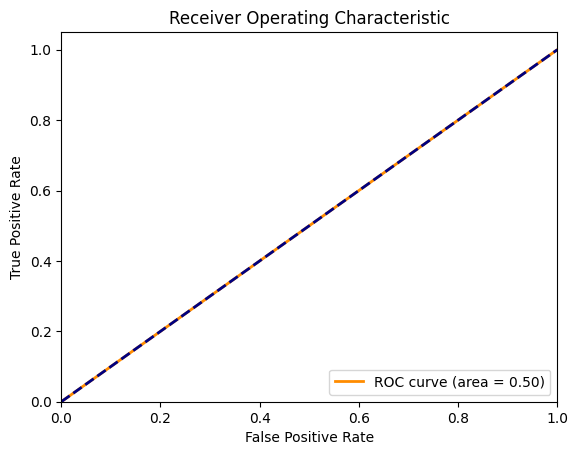

In [161]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score


# Filter out the instances where the prediction is 0
mask = y_pred != 0
y_true_filtered = y_true[mask]
y_pred_filtered = y_pred[mask]

# Binarize the labels
# Here, we assume y_pred_filtered contains probabilities or scores for class 1
y_true_binary = np.where(y_true_filtered == 1, 1, 0)

# Calculate ROC curve
fpr, tpr, _ = roc_curve(y_true_binary, y_pred_filtered)

# Calculate AUC
roc_auc = roc_auc_score(y_true_binary, y_pred_filtered)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


Overall Annual Return: 80.48%
Overall Annual Sharpe Ratio: 1.5075
Maximum Drawdown: -33.1 %
Alpha: -0.0183
Beta: 0.7693

Yearly Metrics:
   year  yearly_return  yearly_std  yearly_beta  yearly_alpha  yearly_sharpe
0  2024       0.804807    0.462763     0.769263     -0.018466       1.507536


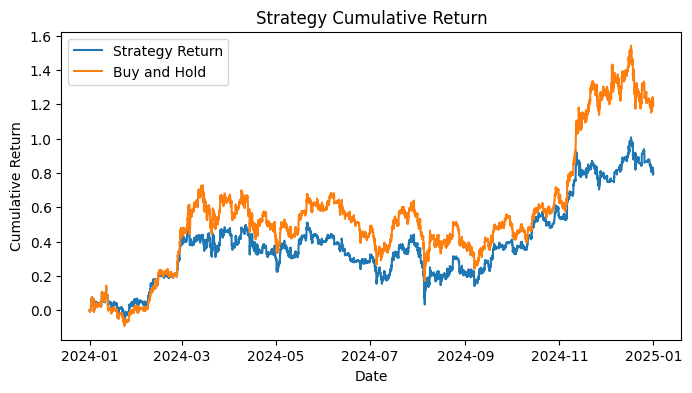

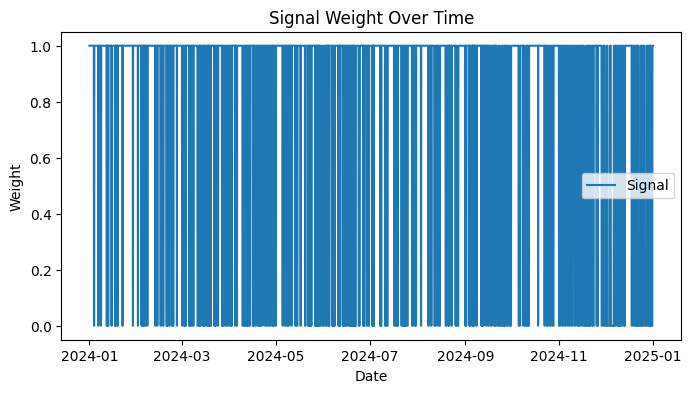

In [162]:
run_backtest(stat_signal_result_df,name="LSTM_Custom_Stat")

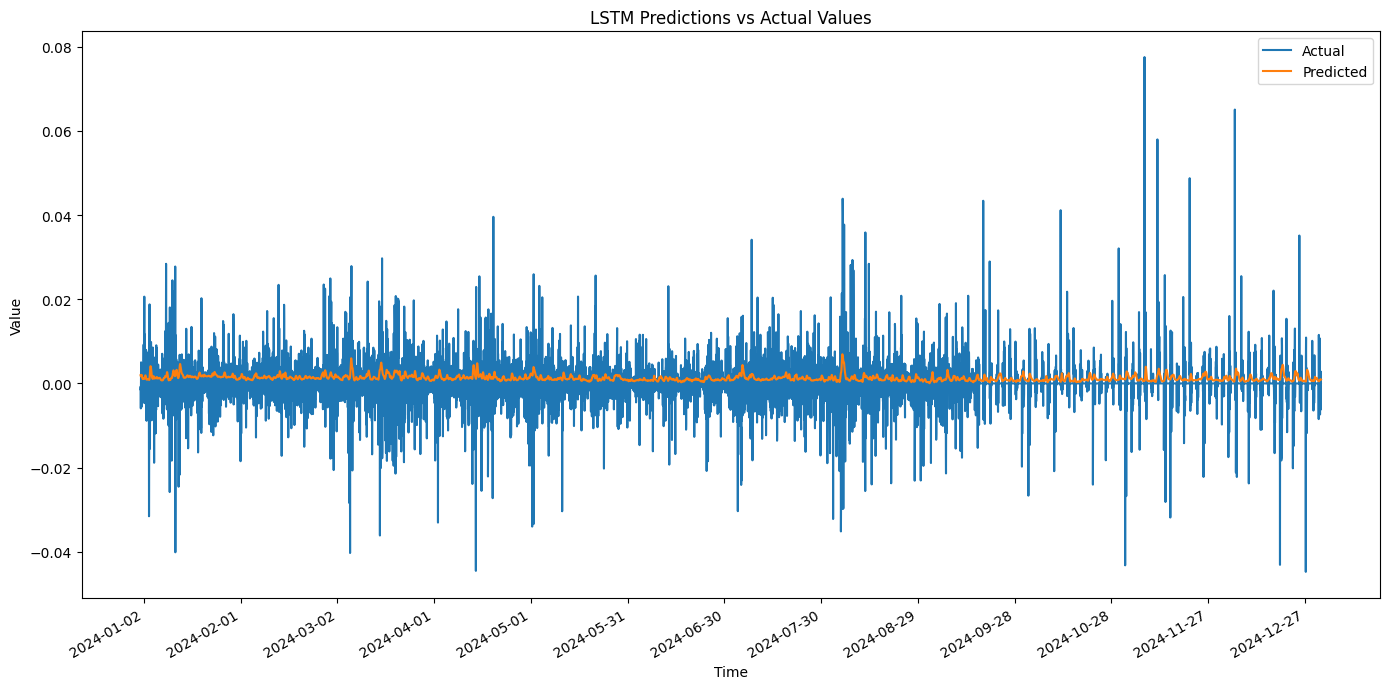

In [130]:
# Now you can plot with proper time indexes
plt.figure(figsize=(14, 7))
plt.plot(results_df.index, results_df['Actual'], label='Actual')
plt.plot(results_df.index, results_df['Predicted'], label='Predicted')

# Format x-axis if using DatetimeIndex
if isinstance(results_df.index, pd.DatetimeIndex):
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=30))
    plt.gcf().autofmt_xdate()

plt.title('LSTM Predictions vs Actual Values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.tight_layout()
plt.show()

In [131]:
stat_signal_result_df
target = df.loc[train_start_date:train_end_date]
target = target

# Sequential Feature Selection

In [132]:
import pickle
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler

# Load the scalers and feature list
with open('./pickles/seq_feature_scaler.pkl', 'rb') as file:
    feature_scaler = pickle.load(file)

with open('./pickles/seq_target_scaler.pkl', 'rb') as file:
    target_scaler = pickle.load(file)

with open('./pickles/seq_selected_features.pkl', 'rb') as file:
    selected_features = pickle.load(file)

In [133]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

X_df = df[selected_features].values
y_df = df['return_forward'].values  # Replace with your target column name
original_indexes = df.index.tolist()

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_df)

# If your target needs scaling too (for regression problems)
y_scaler = MinMaxScaler()
y_scaled = y_scaler.fit_transform(y_df.reshape(-1, 1))

# Define sequence length (time steps to look back)
sequence_length = 12  # Adjust based on your specific problem

# Create sequences for LSTM
X_sequences = []
y_sequences = []
sequence_indexes = []

for i in range(len(X_scaled) - sequence_length):
    X_sequences.append(X_scaled[i:i+sequence_length])
    y_sequences.append(y_scaled[i+sequence_length])
    sequence_indexes.append(original_indexes[i+sequence_length])

# Convert to numpy arrays
X_sequences = np.array(X_sequences)
y_sequences = np.array(y_sequences)

# Check the resulting shapes
print(f"X shape: {X_sequences.shape}")  # Should be (samples, sequence_length, num_features)
print(f"y shape: {y_sequences.shape}")  # Should be (samples, 1) or (samples,)

# Split into training and testing sets

X_train, X_test, y_train, y_test ,train_idx, test_idx = train_test_split(
    X_sequences, y_sequences, sequence_indexes, test_size=0.25062, shuffle=False
)

print(f"Total sequences: {len(sequence_indexes)}")
print(f"Training sequences: {len(train_idx)}")
print(f"Testing sequences: {len(test_idx)}")


X shape: (35046, 12, 15)
y shape: (35046, 1)
Total sequences: 35046
Training sequences: 26262
Testing sequences: 8784


In [134]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K
from keras.saving import register_keras_serializable


from keras.callbacks import LearningRateScheduler

# Define learning rate schedule function
def lr_schedule(epoch, lr):
    if epoch < 10:
        return lr
    elif epoch < 20:
        return lr * 0.1
    else:
        return lr * 0.01

# Create learning rate scheduler callback
lr_scheduler = LearningRateScheduler(lr_schedule)



@register_keras_serializable(package="Custom", name="weighted_loss")
def weighted_loss(y_true, y_pred):
    # Calculate returns
    returns = y_pred - y_true
    
    # Define weights for positive and negative returns
    positive_weight = 0.5
    negative_weight = 1.5
    
    # Calculate weighted loss
    loss = K.mean(K.switch(returns > 0, positive_weight * K.square(returns), negative_weight * K.square(returns)))
    
    return loss


# Define model architecture
model = Sequential()
model.add(LSTM(64, activation='relu', return_sequences=True, 
               input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))  # Output layer - 1 neuron for regression

# Compile model
model.compile(optimizer='adam', loss=weighted_loss)

# Add early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping,lr_scheduler],
    verbose=1
)

# Evaluate model
loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")

# Make predictions
predictions = model.predict(X_test)

# Inverse transform predictions to original scale (if you scaled y)
predictions = y_scaler.inverse_transform(predictions)
y_test_actual = y_scaler.inverse_transform(y_test)
predictions

Epoch 1/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.0194 - val_loss: 3.6106e-04 - learning_rate: 0.0010
Epoch 2/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0033 - val_loss: 2.9835e-04 - learning_rate: 0.0010
Epoch 3/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0022 - val_loss: 2.8745e-04 - learning_rate: 0.0010
Epoch 4/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0016 - val_loss: 2.4678e-04 - learning_rate: 0.0010
Epoch 5/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0011 - val_loss: 2.3318e-04 - learning_rate: 0.0010
Epoch 6/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0010 - val_loss: 2.3956e-04 - learning_rate: 0.0010
Epoch 7/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 9.4581e-04 - val_loss: 2.4321e-04 - learning_rate: 0.0010
Epoch 8/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 8.6466e-04 - val_loss: 2.3500e-04 - learning_rate: 0.0010
Epoch 9/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 9.7519e-04 

array([[0.00218757],
       [0.00239441],
       [0.00240707],
       ...,
       [0.00303077],
       [0.00309446],
       [0.00310131]], dtype=float32)

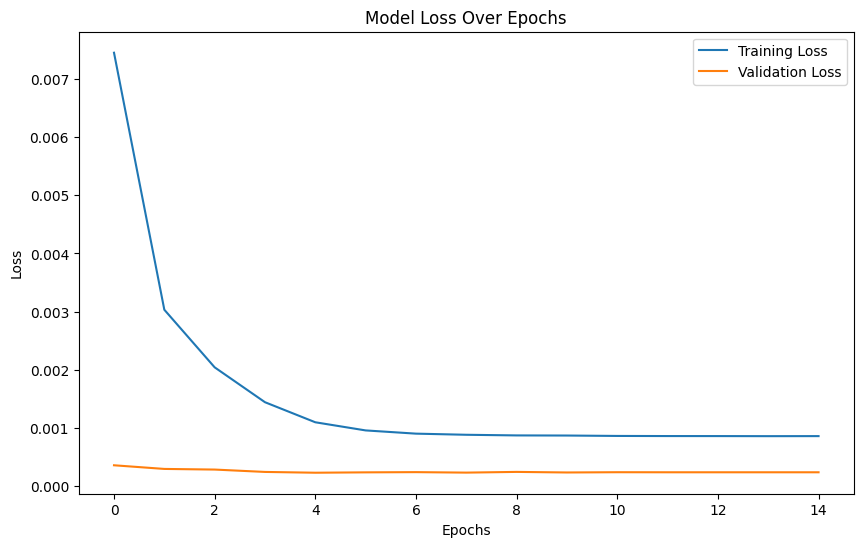

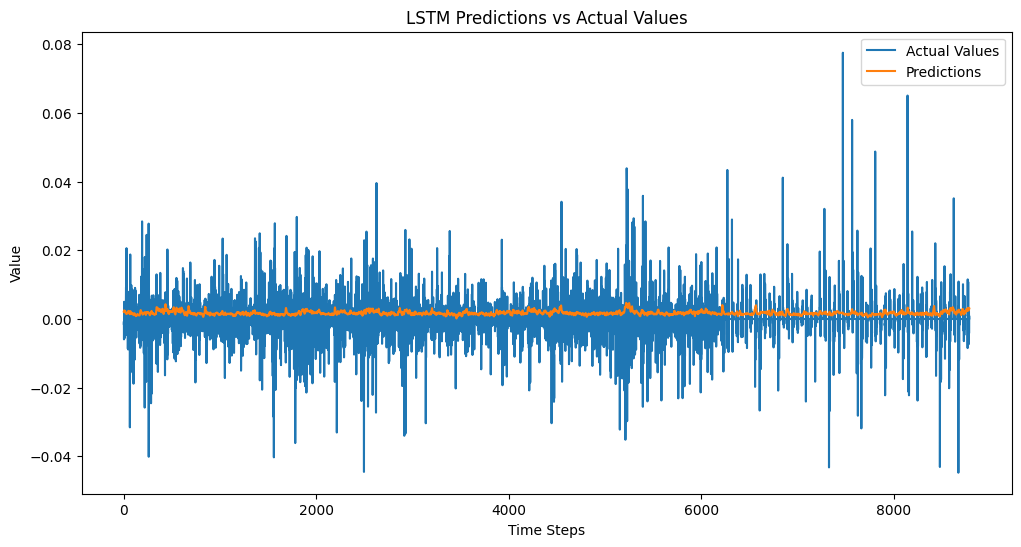

In [135]:
import matplotlib.pyplot as plt

# Plot loss history (for Keras model)
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot predictions vs actual values
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label='Actual Values')
plt.plot(predictions, label='Predictions')
plt.title('LSTM Predictions vs Actual Values')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.legend()
plt.show()

In [136]:
# import pickle

# # Save feature scaler
# with open('seq_feature_scaler.pkl', 'wb') as file:
#     pickle.dump(scaler, file)

# # Save target scaler (if used)
# with open('seq_target_scaler.pkl', 'wb') as file:
#     pickle.dump(y_scaler, file)
    
# # Save feature list
# with open('seq_selected_features.pkl', 'wb') as file:
#     pickle.dump(selected_features, file)

model.save('seq_features_selection_lstm_model_C0.keras')  # HDF5 format


In [163]:
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

model = load_model('seq_features_selection_lstm_model_C0.keras')  # Your saved model
predictions = model.predict(X_test)
predictions = y_scaler.inverse_transform(predictions)
y_test_actual = y_scaler.inverse_transform(y_test)

# Create DataFrame with predictions and actual values with proper indexes
results_df = pd.DataFrame({
    'Actual': y_test_actual.flatten(),
    'Predicted': predictions.flatten()
}, index=test_idx)

stat_signal_result_df = results_df.drop("Actual",axis=1)
stat_signal_result_df['signal'] = stat_signal_result_df['Predicted'].apply(lambda x: 1 if x > 0.002 else (-1 if x < 0.001 else 0))
stat_signal_result_df['target'] = results_df['Actual'].apply(lambda x: 1 if x > 0.002 else (-1 if x < 0.001 else 0))

stat_signal_result_df

275/275 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


,Predicted,signal,target
2024-01-01 00:00:00,0.005004,1,-1
2024-01-01 01:00:00,0.005123,1,-1
2024-01-01 02:00:00,0.005146,1,-1
2024-01-01 03:00:00,0.005171,1,-1
2024-01-01 04:00:00,0.004978,1,1
...,...,...,...
2024-12-31 19:00:00,0.003897,1,-1
2024-12-31 20:00:00,0.004023,1,1
2024-12-31 21:00:00,0.003710,1,-1
2024-12-31 22:00:00,0.003745,1,-1


In [164]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming 'stat_signal_result_df' is the DataFrame created in the previous cell
y_true = stat_signal_result_df['target']
y_pred = stat_signal_result_df['signal']

# Calculate metrics
# Use 'weighted' average for multi-class classification to account for label imbalance
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (Weighted): {precision:.4f}")
print(f"Recall (Weighted): {recall:.4f}")
print(f"F1 Score (Weighted): {f1:.4f}")

# If you want metrics for each class (e.g., -1, 0, 1)
print("\\nMetrics per class:")
precision_per_class = precision_score(y_true, y_pred, average=None, zero_division=0)
recall_per_class = recall_score(y_true, y_pred, average=None, zero_division=0)
f1_per_class = f1_score(y_true, y_pred, average=None, zero_division=0)
labels = sorted(y_true.unique()) # Get the unique class labels

for i, label in enumerate(labels):
    print(f"  Class {label}:")
    print(f"    Precision: {precision_per_class[i]:.4f}")
    print(f"    Recall:    {recall_per_class[i]:.4f}")
    print(f"    F1 Score:  {f1_per_class[i]:.4f}")


Accuracy: 0.2434
Precision (Weighted): 0.0624
Recall (Weighted): 0.2434
F1 Score (Weighted): 0.0980
\nMetrics per class:
  Class -1:
    Precision: 0.0000
    Recall:    0.0000
    F1 Score:  0.0000
  Class 0:
    Precision: 0.0194
    Recall:    0.0056
    F1 Score:  0.0087
  Class 1:
    Precision: 0.2488
    Recall:    0.9939
    F1 Score:  0.3979


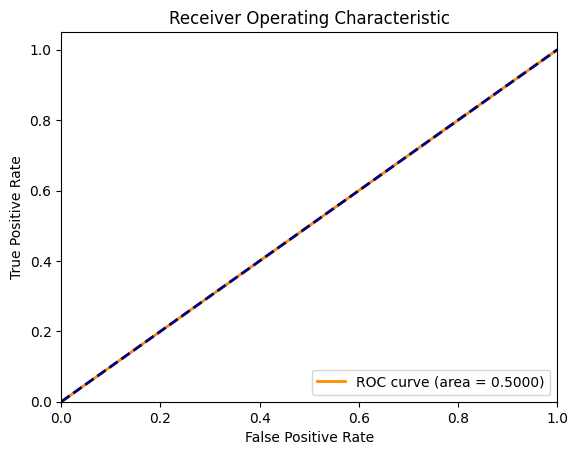

In [165]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score


# Filter out the instances where the prediction is 0
mask = y_pred != 0
y_true_filtered = y_true[mask]
y_pred_filtered = y_pred[mask]

# Binarize the labels
# Here, we assume y_pred_filtered contains probabilities or scores for class 1
y_true_binary = np.where(y_true_filtered == 1, 1, 0)

# Calculate ROC curve
fpr, tpr, _ = roc_curve(y_true_binary, y_pred_filtered)

# Calculate AUC
roc_auc = roc_auc_score(y_true_binary, y_pred_filtered)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


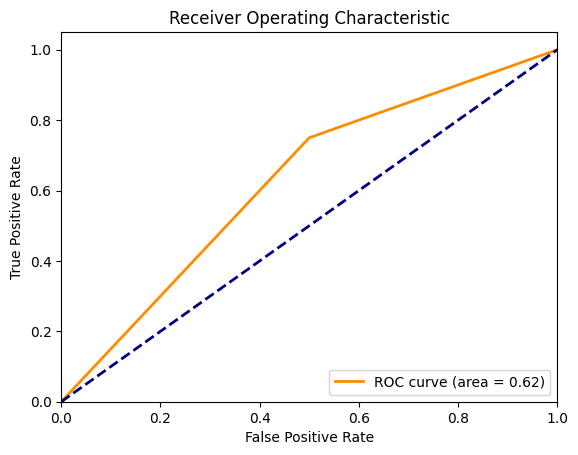

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Filter out the instances where the prediction is 0
mask = y_pred != 0
y_true_filtered = y_true[mask]
y_pred_filtered = y_pred[mask]

# Binarize the labels
# Here, we assume y_pred_filtered contains probabilities or scores for class 1
y_true_binary = np.where(y_true_filtered == 1, 1, 0)

# Calculate ROC curve
fpr, tpr, _ = roc_curve(y_true_binary, y_pred_filtered)

# Calculate AUC
roc_auc = roc_auc_score(y_true_binary, y_pred_filtered)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


Overall Annual Return: 118.26%
Overall Annual Sharpe Ratio: 1.7522
Maximum Drawdown: -32.33 %
Alpha: 0.0003
Beta: 0.9856

Yearly Metrics:
   year  yearly_return  yearly_std  yearly_beta  yearly_alpha  yearly_sharpe
0  2024       1.182602    0.523791      0.98562      0.000293       1.752215


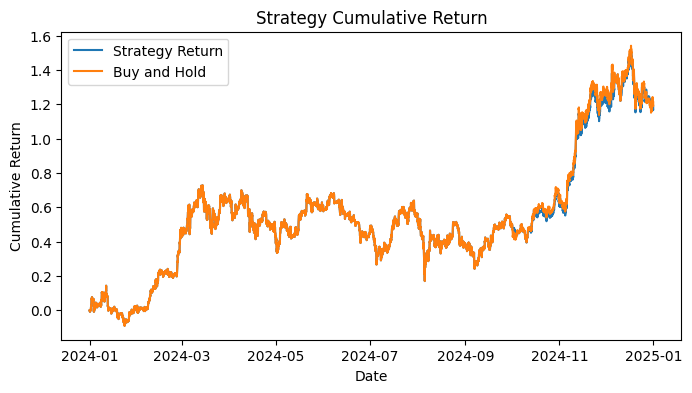

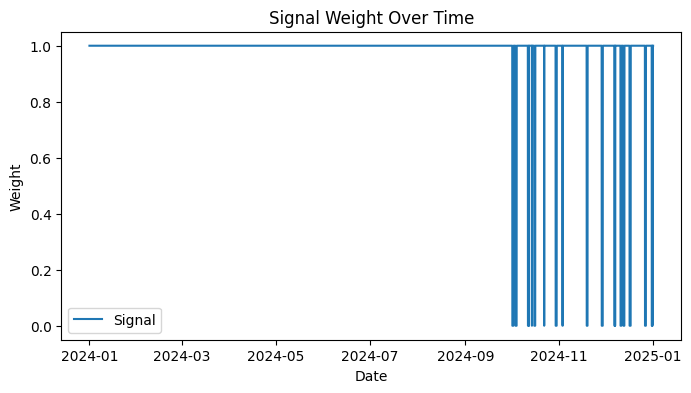

In [167]:
run_backtest(stat_signal_result_df, name ="LSTM_Custom_Seq")

# Hybrid Pipeline

In [142]:
import pickle
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler

# Load the scalers and feature list
with open('./pickles/hybrid_feature_scaler.pkl', 'rb') as file:
    feature_scaler = pickle.load(file)

with open('./pickles/hybrid_target_scaler.pkl', 'rb') as file:
    target_scaler = pickle.load(file)

with open('./pickles/hybrid_selected_features.pkl', 'rb') as file:
    selected_features = pickle.load(file)

In [143]:
print(lstm_features)

['target', 'atr_7', 'trailing_stop_long_7', '10_band_width', '20_band_width', 'pct_b_10', 'sma_50_200_diff', 'reddit_total_sentiment_ewm_5h', 'rsi_7_acceleration', 'adx', 'sma_20_50_diff', 'tanalysis_absa_ewm_12h', 'sma_50_200_diff_pct_chg', 'reddit_total_sentiment_ewm_24h', 'sma_5_20_diff_pct_chg']


In [144]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

X_df = df[selected_features].values
y_df = df['return_forward'].values  # Replace with your target column name
original_indexes = df.index.tolist()

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_df)

# If your target needs scaling too (for regression problems)
y_scaler = MinMaxScaler()
y_scaled = y_scaler.fit_transform(y_df.reshape(-1, 1))

# Define sequence length (time steps to look back)
sequence_length = 12  # Adjust based on your specific problem

# Create sequences for LSTM
X_sequences = []
y_sequences = []
sequence_indexes = []

for i in range(len(X_scaled) - sequence_length):
    X_sequences.append(X_scaled[i:i+sequence_length])
    y_sequences.append(y_scaled[i+sequence_length])
    sequence_indexes.append(original_indexes[i+sequence_length])

# Convert to numpy arrays
X_sequences = np.array(X_sequences)
y_sequences = np.array(y_sequences)

# Check the resulting shapes
print(f"X shape: {X_sequences.shape}")  # Should be (samples, sequence_length, num_features)
print(f"y shape: {y_sequences.shape}")  # Should be (samples, 1) or (samples,)

# Split into training and testing sets

X_train, X_test, y_train, y_test ,train_idx, test_idx = train_test_split(
    X_sequences, y_sequences, sequence_indexes, test_size=0.25062, shuffle=False
)

print(f"Total sequences: {len(sequence_indexes)}")
print(f"Training sequences: {len(train_idx)}")
print(f"Testing sequences: {len(test_idx)}")


X shape: (35046, 12, 15)
y shape: (35046, 1)
Total sequences: 35046
Training sequences: 26262
Testing sequences: 8784


In [145]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K
from keras.saving import register_keras_serializable


from keras.callbacks import LearningRateScheduler

# Define learning rate schedule function
def lr_schedule(epoch, lr):
    if epoch < 10:
        return lr
    elif epoch < 20:
        return lr * 0.1
    else:
        return lr * 0.01

# Create learning rate scheduler callback
lr_scheduler = LearningRateScheduler(lr_schedule)



@register_keras_serializable(package="Custom", name="weighted_loss")
def weighted_loss(y_true, y_pred):
    # Calculate returns
    returns = y_pred - y_true
    
    # Define weights for positive and negative returns
    positive_weight = 0.5
    negative_weight = 1.5
    
    # Calculate weighted loss
    loss = K.mean(K.switch(returns > 0, positive_weight * K.square(returns), negative_weight * K.square(returns)))
    
    return loss


# Define model architecture
model = Sequential()
model.add(LSTM(64, activation='relu', return_sequences=True, 
               input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))  # Output layer - 1 neuron for regression

# Compile model
model.compile(optimizer='adam', loss=weighted_loss)

# Add early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping,lr_scheduler],
    verbose=1
)

# Evaluate model
loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")

# Make predictions
predictions = model.predict(X_test)

# Inverse transform predictions to original scale (if you scaled y)
predictions = y_scaler.inverse_transform(predictions)
y_test_actual = y_scaler.inverse_transform(y_test)
predictions

Epoch 1/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.0143 - val_loss: 4.5327e-04 - learning_rate: 0.0010
Epoch 2/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0029 - val_loss: 2.4058e-04 - learning_rate: 0.0010
Epoch 3/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0020 - val_loss: 3.0148e-04 - learning_rate: 0.0010
Epoch 4/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0013 - val_loss: 2.3867e-04 - learning_rate: 0.0010
Epoch 5/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0011 - val_loss: 2.3377e-04 - learning_rate: 0.0010
Epoch 6/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 9.4849e-04 - val_loss: 2.3781e-04 - learning_rate: 0.0010
Epoch 7/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 9.1653e-04 - val_loss: 2.3631e-04 - learning_rate: 0.0010
Epoch 8/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 8.8065e-04 - val_loss: 2.3085e-04 - learning_rate: 0.0010
Epoch 9/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 8.8931e

array([[0.00154452],
       [0.00152909],
       [0.00153333],
       ...,
       [0.00210309],
       [0.00218881],
       [0.00226362]], dtype=float32)

In [146]:
# import pickle

# # Save feature scaler
# with open('hybrid_feature_scaler.pkl', 'wb') as file:
#     pickle.dump(scaler, file)

# # Save target scaler (if used)
# with open('hybrid_target_scaler.pkl', 'wb') as file:
#     pickle.dump(y_scaler, file)
    
# # Save feature list
# with open('hybrid_selected_features.pkl', 'wb') as file:
#     pickle.dump(selected_features, file)

model.save('hybrid_features_selection_lstm_model_C0.keras')  # HDF5 format


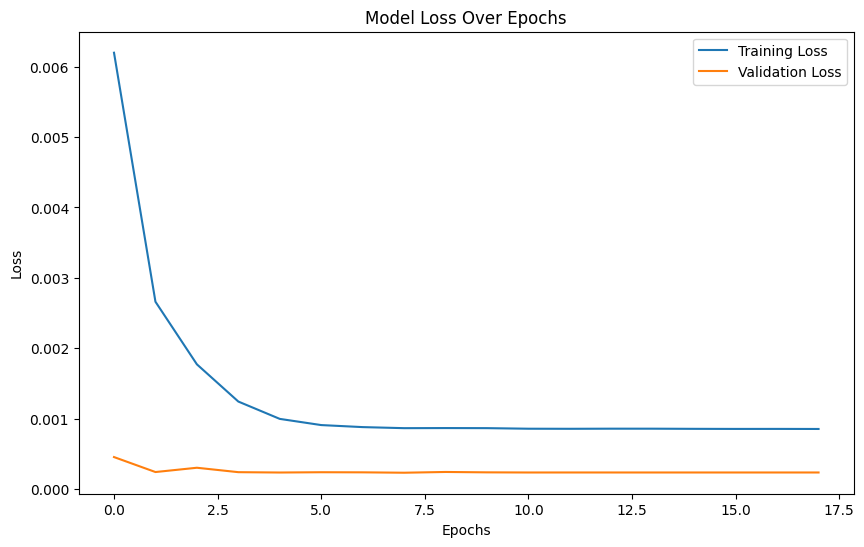

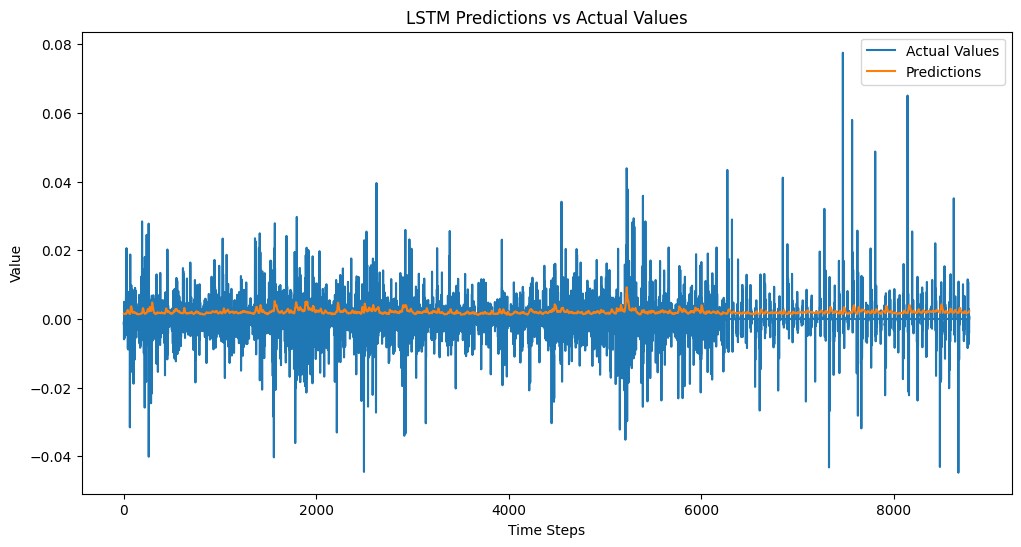

In [147]:
import matplotlib.pyplot as plt

# Plot loss history (for Keras model)
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot predictions vs actual values
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label='Actual Values')
plt.plot(predictions, label='Predictions')
plt.title('LSTM Predictions vs Actual Values')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.legend()
plt.show()

In [148]:
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

model = load_model('hybrid_features_selection_lstm_model_C0.keras')  # Your saved model
predictions = model.predict(X_test)
predictions = y_scaler.inverse_transform(predictions)
y_test_actual = y_scaler.inverse_transform(y_test)

# Create DataFrame with predictions and actual values with proper indexes
results_df = pd.DataFrame({
    'Actual': y_test_actual.flatten(),
    'Predicted': predictions.flatten()
}, index=test_idx)

stat_signal_result_df = results_df.drop("Actual",axis=1)
stat_signal_result_df['signal'] = stat_signal_result_df['Predicted'].apply(lambda x: 1 if x > 0.002 else (-1 if x < 0.001 else 0))
stat_signal_result_df['target'] = results_df['Actual'].apply(lambda x: 1 if x > 0.002 else (-1 if x < 0.001 else 0))

stat_signal_result_df

275/275 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


,Predicted,signal,target
2024-01-01 00:00:00,0.001545,0,-1
2024-01-01 01:00:00,0.001529,0,-1
2024-01-01 02:00:00,0.001533,0,-1
2024-01-01 03:00:00,0.001507,0,-1
2024-01-01 04:00:00,0.001475,0,1
...,...,...,...
2024-12-31 19:00:00,0.002025,1,-1
2024-12-31 20:00:00,0.002045,1,1
2024-12-31 21:00:00,0.002103,1,-1
2024-12-31 22:00:00,0.002189,1,-1


In [149]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming 'stat_signal_result_df' is the DataFrame created in the previous cell
y_true = stat_signal_result_df['target']
y_pred = stat_signal_result_df['signal']

# Calculate metrics
# Use 'weighted' average for multi-class classification to account for label imbalance
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (Weighted): {precision:.4f}")
print(f"Recall (Weighted): {recall:.4f}")
print(f"F1 Score (Weighted): {f1:.4f}")

# If you want metrics for each class (e.g., -1, 0, 1)
print("\\nMetrics per class:")
precision_per_class = precision_score(y_true, y_pred, average=None, zero_division=0)
recall_per_class = recall_score(y_true, y_pred, average=None, zero_division=0)
f1_per_class = f1_score(y_true, y_pred, average=None, zero_division=0)
labels = sorted(y_true.unique()) # Get the unique class labels

for i, label in enumerate(labels):
    print(f"  Class {label}:")
    print(f"    Precision: {precision_per_class[i]:.4f}")
    print(f"    Recall:    {recall_per_class[i]:.4f}")
    print(f"    F1 Score:  {f1_per_class[i]:.4f}")


Accuracy: 0.1712
Precision (Weighted): 0.0750
Recall (Weighted): 0.1712
F1 Score (Weighted): 0.0997
\nMetrics per class:
  Class -1:
    Precision: 0.0000
    Recall:    0.0000
    F1 Score:  0.0000
  Class 0:
    Precision: 0.0873
    Recall:    0.6000
    F1 Score:  0.1525
  Class 1:
    Precision: 0.2777
    Recall:    0.5007
    F1 Score:  0.3573


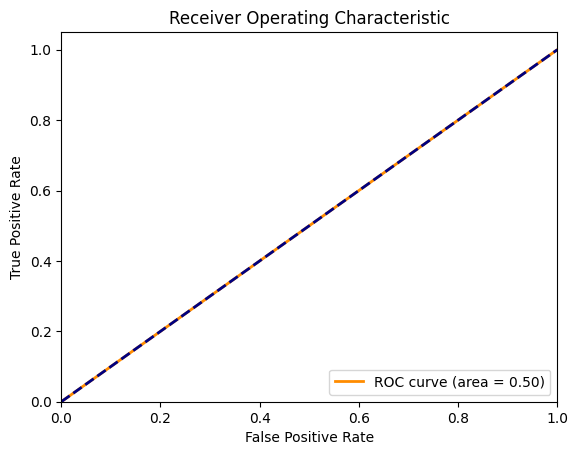

In [150]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score


mask = y_pred != 0
y_true_filtered = y_true[mask]
y_pred_filtered = y_pred[mask]

# Binarize the labels
# Here, we assume y_pred_filtered contains probabilities or scores for class 1
y_true_binary = np.where(y_true_filtered == 1, 1, 0)

# Calculate ROC curve
fpr, tpr, _ = roc_curve(y_true_binary, y_pred_filtered)

# Calculate AUC
roc_auc = roc_auc_score(y_true_binary, y_pred_filtered)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


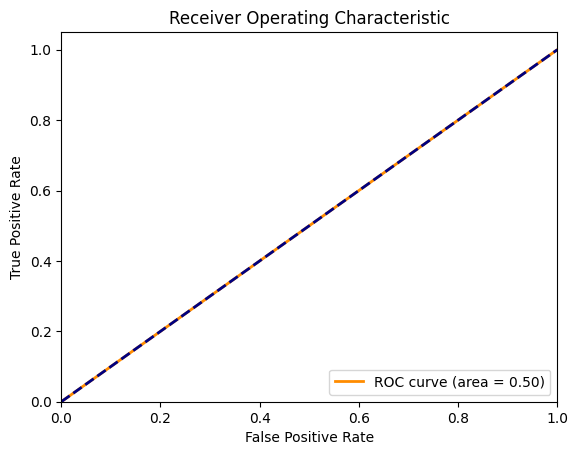

In [151]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score


# Filter out the instances where the prediction is 0
mask = y_pred != 0
y_true_filtered = y_true[mask]
y_pred_filtered = y_pred[mask]

# Binarize the labels
# Here, we assume y_pred_filtered contains probabilities or scores for class 1
y_true_binary = np.where(y_true_filtered == 1, 1, 0)

# Calculate ROC curve
fpr, tpr, _ = roc_curve(y_true_binary, y_pred_filtered)

# Calculate AUC
roc_auc = roc_auc_score(y_true_binary, y_pred_filtered)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


Overall Annual Return: 9.76%
Overall Annual Sharpe Ratio: 0.4329
Maximum Drawdown: -33.5 %
Alpha: -0.3027
Beta: 0.5731

Yearly Metrics:
   year  yearly_return  yearly_std  yearly_beta  yearly_alpha  yearly_sharpe
0  2024       0.097568    0.399415     0.573064     -0.360539       0.432932


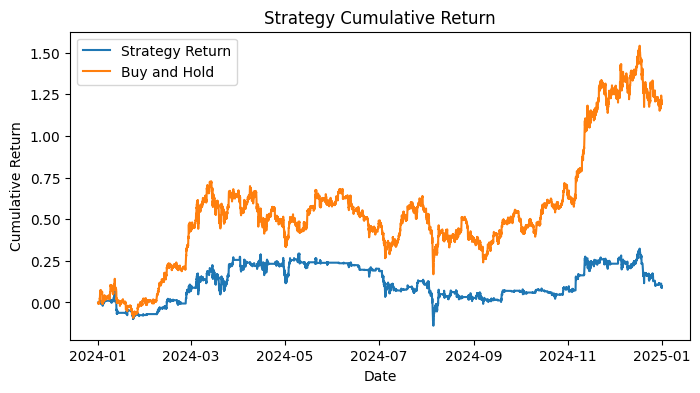

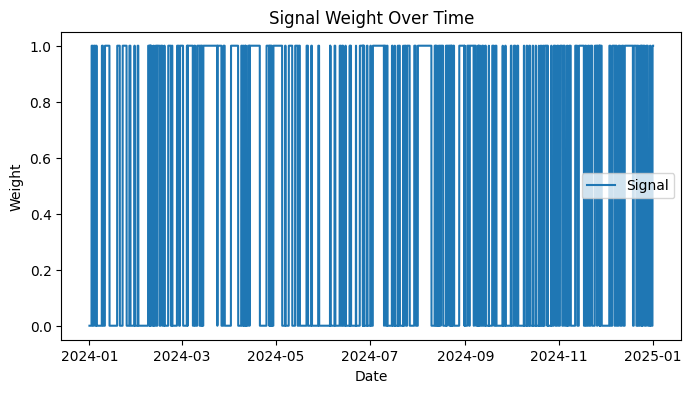

In [152]:
run_backtest(stat_signal_result_df, name ="LSTM_Custom_Hybrid")